In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib

import importlib
from pathlib import Path
import sys
sys.path.append(str(Path("/Users/xunan/Projects/MaxEnt/Code/numpy")))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [9]:
img  = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/REDIM_diravg.nii.gz")
mask = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/B0_WMPARC.nii.gz")

signal = np.flip(img.get_fdata(), axis = 0) # flip it such that it matches the indices in MRView
seg = np.flip(mask.get_fdata(), axis = 0)

print(signal.shape)

(96, 96, 54, 30)


In [10]:
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/bvals.txt") / 1000 # in unit ms/{\mu m} ^2
TEs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/TEs.txt")/1000  # in unit s
qs = np.column_stack((bvals, TEs))

In [11]:
signal_norm = signal[:,:,:,qs[:,0]!=0] / np.repeat(signal[:,:,:,qs[:,0]==0], 5, axis = -1)
qs_norm = np.delete(qs, qs[:, 0] == 0, axis = 0)

In [100]:
Sqs = signal_norm[30:35, 35:40, 35, :].reshape((-1, qs_norm.shape[0]), order = 'C')

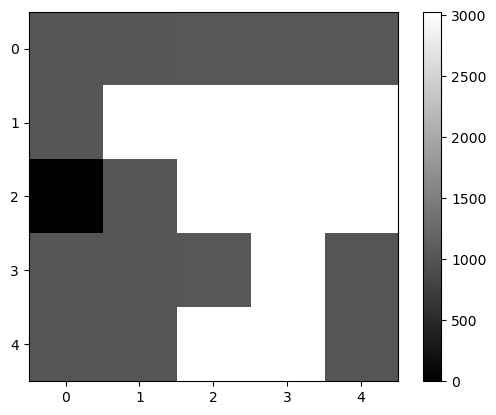

In [101]:
plt.imshow(np.fliplr(np.rot90(seg[30:35, 35:40, 35])), cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()


In [102]:
theta1 = np.linspace(0, 3, 50)
theta2 = np.linspace(0, 40, 50)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_plane_2D(5, 5, 25, order = 2)

In [103]:
std_vector = 0.05*np.ones(len(Sqs))
sigma = np.repeat(std_vector, 25)

for i in range(1):
    _, f_est, _ = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                            R_csr = sp.csr_matrix(R.shape), f0 = None, normalize = True,
                            Lambdas = None, rho = 1, rho_ratio = 10, dynamic_rho = True, 
                            beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 5,
                            cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                            admm_tol = 1e-10, admm_maxiter = 100)

    Sqs_est = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_est)

    diff = Sqs - Sqs_est
    std_vector = np.std(diff, axis = 1)
    sigma = np.repeat(std_vector, 25)


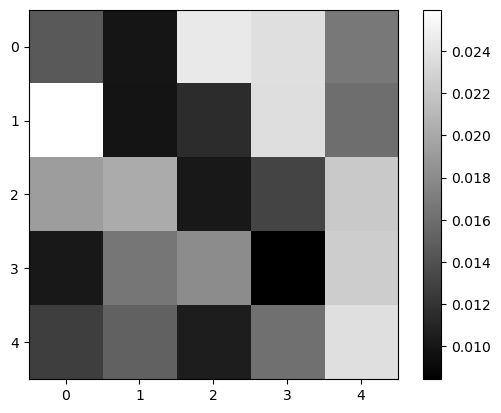

In [109]:
plt.imshow(np.fliplr(np.rot90(std_vector.reshape((5, 5)))), cmap = 'gray')
plt.colorbar()


In [110]:
# sigma[sigma <= 0.01] = 0.01
print("Mean of sigma is:", np.mean(sigma))

Mean of sigma is: 0.016600090948507572


In [106]:
lambdas, f_hat, obj_history = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                                        R_csr = R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 0.5, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 100)


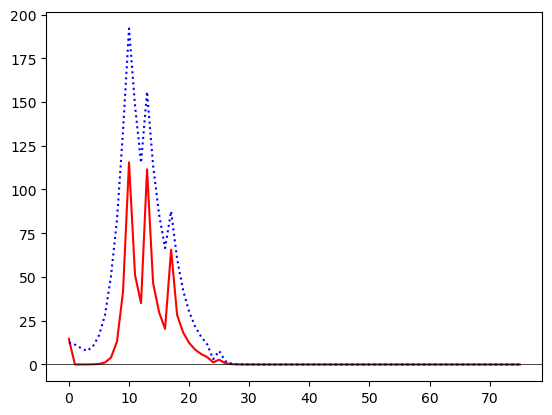

In [107]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

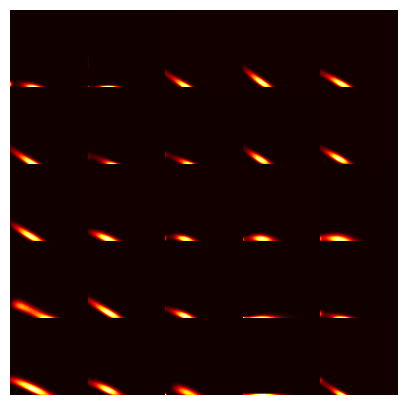

In [108]:
# the rows is the rows of image in the MRView, the cols is the cols.
# Since the cols in the image is the first dimension in the signal,
# So, the signal is in dimension 56*57, and the plots are in 57*56

rows = 5
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(5, 5)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for j in range(cols):
    for i in range(rows):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, f_hat[rows*(cols - 1 - j)+(rows - 1 - i)].reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        # ax.text(0.02, 0.02, f'{15*(14 - i)+(14 - j)}', color='white', fontsize=8,
        #         transform=ax.transAxes, ha='left', va='bottom')
        ax.axis("off")
plt.show()

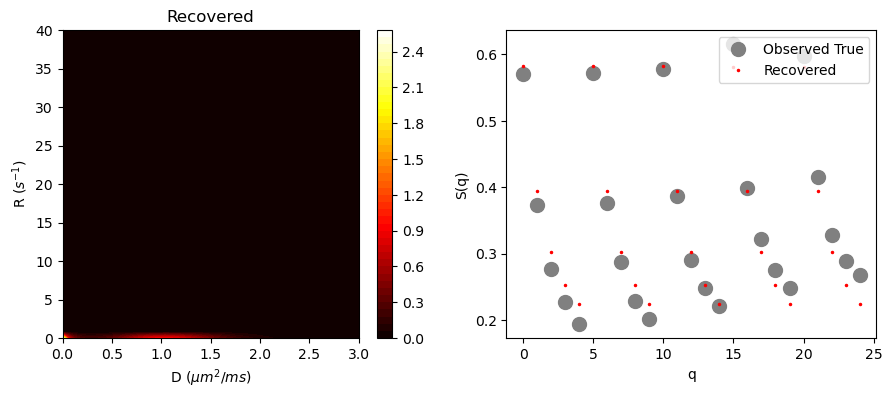

In [59]:
bf.contourf_compare(theta1, theta2, f_hat = f_hat[0].ravel(), qs = qs_norm, Sqs = Sqs[0].ravel(), f_true = None, savepath = None)

# Cross Validation

In [113]:
R_24 = rr.R_plane_2D(5, 5, 24, order = 2)

alpha_list = np.array([0.1, 0.25, 0.5, 1, 2])
beta_list = np.array([0, 1e0, 1e1, 1e2])

loss_table = np.zeros((len(alpha_list), len(beta_list)))

for m, alpha in enumerate(alpha_list):
    for n, beta in enumerate(beta_list):

        loss = 0

        for i in range(25):
            _, f_CV, _ = das.admm(  np.delete(qs_norm, i, axis=0), thetas, weights, np.delete(Sqs, i, axis=1), 
                                    sigma = alpha * np.delete(sigma.reshape(-1, 25), i, axis=1).ravel(),
                                    R_csr = beta * R_24, 
                                    f0 = None, normalize = True,
                                    Lambdas = None, rho = 0.5, rho_ratio = 3, dynamic_rho = True,
                                    beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                    cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                    admm_tol = 1e-10, admm_maxiter = 100)
            
            Sqs_CV = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_CV)
            loss += np.sum((Sqs_CV[:, i] - Sqs[:, i])**2)
        loss_table[m, n] = loss
        print("Finished: m=", m, "n=", n)



ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.
ADMM maximum iterations reached.


KeyboardInterrupt: 

In [112]:
loss_table

array([[0.20736295, 0.20733422, 0.20711739, 0.20811978],
       [0.21041772, 0.2103248 , 0.2100758 , 0.23243105],
       [0.2291268 , 0.2288813 , 0.23325955, 0.34027466]])

In [221]:

_, f_CV, _ = das.admm(  np.delete(qs_norm, i, axis=0), thetas, weights, np.delete(Sqs, i, axis=1), 
                        sigma = alpha * np.delete(sigma.reshape(-1, 25), i, axis=1).ravel(),
                        R_csr = beta * R_24, 
                        f0 = None, normalize = True,
                        Lambdas = None, rho = 0.5, rho_ratio = 3,dynamic_rho = True,
                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                        admm_tol = 1e-8, admm_maxiter = 200)

Sqs_CV = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_CV)

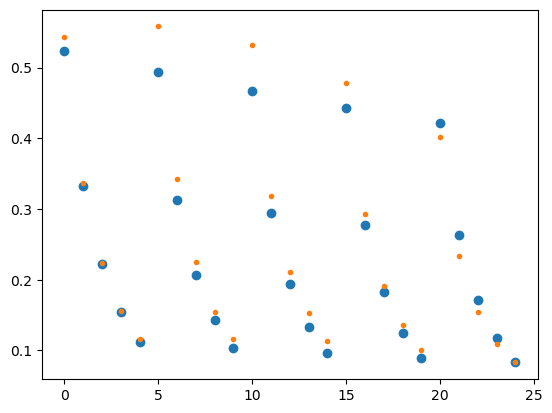

In [222]:
plt.plot(Sqs_CV[1, :], 'o')
plt.plot(Sqs[1, :], '.')